**Part1**

In [1]:
!pip install gymnasium

In [2]:
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

In [3]:
class SimulationParams(NamedTuple):
    num_episodes: int  # Total episodes
    alpha: float  # Learning rate
    discount_factor: float  # Discounting rate
    exploration_prob: float  # Exploration probability
    grid_size: int  # Number of tiles of one side of the squared environment
    random_seed: int  # Define a seed so that we get reproducible results
    terrain_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    iterations: int  # Number of runs
    num_actions: int  # Number of possible actions
    num_states: int  # Number of possible states
    frozen_tile_probability: float  # Probability that a tile is frozen
    output_folder: Path  # Root folder where plots are saved



simulationparams = SimulationParams(
    num_episodes=2000,
    alpha=0.5,
    discount_factor=0.95,
    exploration_prob=0.1,
    grid_size=5,
    random_seed=123,
    terrain_slippery=False,
    iterations=20,
    num_actions=None,
    num_states=None,
    frozen_tile_probability=0.9,
    output_folder=Path("../../_static/img/tutorials/"),
)
simulationparams

# Set the seed
rng = np.random.default_rng(simulationparams.random_seed)

# Create the figure folder if it doesn't exists
simulationparams.output_folder.mkdir(parents=True, exist_ok=True)

In [4]:
environment = gym.make(
    "FrozenLake-v1",
    is_slippery=simulationparams.terrain_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=simulationparams.grid_size, p=simulationparams.frozen_tile_probability, seed=simulationparams.random_seed
    ),
)

In [5]:
# Update the simulationparams to include action_size and state_size
simulationparams = simulationparams._replace(num_actions=environment.action_space.n)
simulationparams = simulationparams._replace(num_states=environment.observation_space.n)

# Print action size and state size
print(f"Action size: {simulationparams.num_actions}")
print(f"State size: {simulationparams.num_states}")


class QLearningAgent:
    def __init__(self, alpha, discount_factor, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.discount_factor = discount_factor
        self.reset_qtable()

    def update_qvalue(self, state, action, reward, next_state):
        """Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.discount_factor * np.max(self.qtable[next_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.alpha * delta
        self.qtable[state, action] = q_update
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.num_states, self.num_actions))


class EpsilonGreedyPolicy:
    def __init__(self, exploration_prob):
        self.exploration_prob = exploration_prob

    def choose_action(self, action_space, current_state, qtable):
        """Choose an action `a` in the current state."""
        # Random number to decide exploration or exploitation
        exploration_tradeoff = rng.uniform(0, 1)

        # Exploration
        if exploration_tradeoff < self.exploration_prob:
            action = action_space.sample()

        # Exploitation (choosing the action with the highest Q-value)
        else:
            # Break ties randomly
            if np.all(qtable[current_state, :] == qtable[current_state, 0]):
                action = action_space.sample()
            else:
                action = np.argmax(qtable[current_state, :])
        return action


Action size: 4
State size: 25


In [6]:
# Instantiate the Q-learning agent
learner = QLearningAgent(
    alpha=simulationparams.alpha,
    discount_factor=simulationparams.discount_factor,
    num_states=simulationparams.num_states,
    num_actions=simulationparams.num_actions,
)

# Instantiate the epsilon-greedy policy
explorer = EpsilonGreedyPolicy(
    exploration_prob=simulationparams.exploration_prob,
)


In [7]:
def execute_simulation():
    rewards_matrix = np.zeros((simulationparams.num_episodes, simulationparams.iterations))
    steps_matrix = np.zeros((simulationparams.num_episodes, simulationparams.iterations))
    episode_indices = np.arange(simulationparams.num_episodes)
    qtables_collection = np.zeros((simulationparams.iterations, simulationparams.num_states, simulationparams.num_actions))
    logged_states = []
    logged_actions = []

    for run_index in range(simulationparams.iterations):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode_index in tqdm(
            episode_indices, desc=f"Run {run_index}/{simulationparams.iterations} - Episodes", leave=False
        ):
            current_state = environment.reset(seed=simulationparams.random_seed)[0]  # Reset the environment
            step_counter = 0
            is_done = False
            accumulated_rewards = 0

            while not is_done:
                chosen_action = explorer.choose_action(
                    action_space=environment.action_space,
                    current_state=current_state,
                    qtable=learner.qtable
                )

                # Log all states and actions
                logged_states.append(current_state)
                logged_actions.append(chosen_action)

                # Take the action and observe the outcome
                next_state, reward, is_terminated, is_truncated, info = environment.step(chosen_action)

                is_done = is_terminated or is_truncated

                learner.qtable[current_state, chosen_action] = learner.update_qvalue(
                    current_state, chosen_action, reward, next_state
                )

                accumulated_rewards += reward
                step_counter += 1

                # Transition to the next state
                current_state = next_state

            # Log rewards and steps for this episode
            rewards_matrix[episode_index, run_index] = accumulated_rewards
            steps_matrix[episode_index, run_index] = step_counter
        qtables_collection[run_index, :, :] = learner.qtable

    return rewards_matrix, steps_matrix, episode_indices, qtables_collection, logged_states, logged_actions


In [8]:
def process_simulation_results(episode_indices, simulationparams, rewards_matrix, steps_matrix, grid_size):
    """Convert the results of the simulation into dataframes."""
    results_df = pd.DataFrame(
        data={
            "Episodes": np.tile(episode_indices, reps=simulationparams.iterations),
            "Rewards": rewards_matrix.flatten(),
            "Steps": steps_matrix.flatten(),
        }
    )
    results_df["Cumulative_Rewards"] = rewards_matrix.cumsum(axis=0).flatten(order="F")
    results_df["Grid_Size"] = np.repeat(f"{grid_size}x{grid_size}", results_df.shape[0])

    steps_summary_df = pd.DataFrame(
        data={"Episodes": episode_indices, "Average_Steps": steps_matrix.mean(axis=1)}
    )
    steps_summary_df["Grid_Size"] = np.repeat(f"{grid_size}x{grid_size}", steps_summary_df.shape[0])

    return results_df, steps_summary_df


In [9]:
def get_best_actions_map(qtable, grid_size):
    """Get the best learned action & map it to arrows."""
    qtable_max_values = qtable.max(axis=1).reshape(grid_size, grid_size)
    qtable_best_actions = np.argmax(qtable, axis=1).reshape(grid_size, grid_size)
    direction_map = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_actions.flatten().shape, dtype=str)
    epsilon = np.finfo(float).eps  # Minimum float number on the machine

    for idx, val in enumerate(qtable_best_actions.flatten()):
        if qtable_max_values.flatten()[idx] > epsilon:
            # Assign an arrow only if a minimal Q-value has been learned as the best action
            # otherwise, since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = direction_map[val]

    qtable_directions = qtable_directions.reshape(grid_size, grid_size)
    return qtable_max_values, qtable_directions


In [10]:
def plot_best_actions_map(qtable, environment, grid_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_max_values, qtable_directions = get_best_actions_map(qtable, grid_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax[0].imshow(environment.render())
    ax[0].axis("off")
    ax[0].set_title("Last Frame")

    # Plot the policy
    sns.heatmap(
        qtable_max_values,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    
    img_title = f"frozenlake_q_values_{grid_size}x{grid_size}.png"
    fig.savefig(simulationparams.output_folder / img_title, bbox_inches="tight")
    plt.show()


In [11]:
def plot_states_actions_distribution(all_states, all_actions, grid_size):
    """Plot the distributions of states and actions."""
    action_labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    sns.histplot(data=all_states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=all_actions, ax=ax[1])
    ax[1].set_xticks(list(action_labels.values()), labels=action_labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    
    img_title = f"frozenlake_states_actions_distrib_{grid_size}x{grid_size}.png"
    fig.savefig(simulationparams.output_folder / img_title, bbox_inches="tight")
    plt.show()


Grid size: 4x4


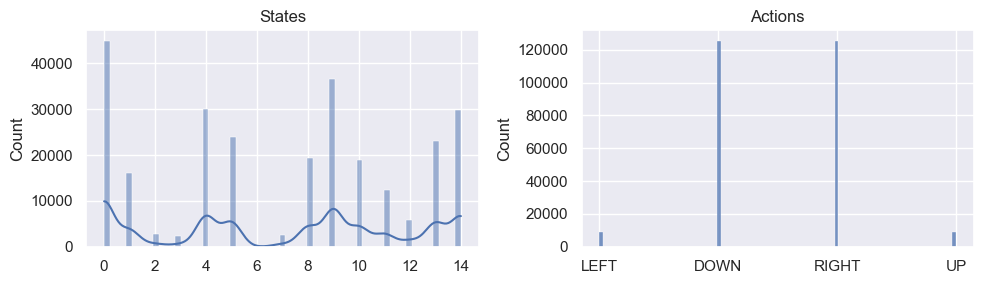

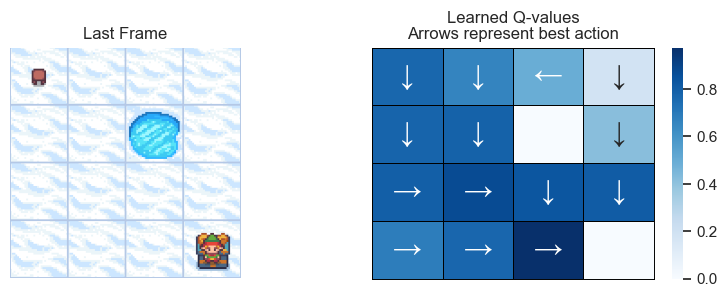

Grid size: 7x7


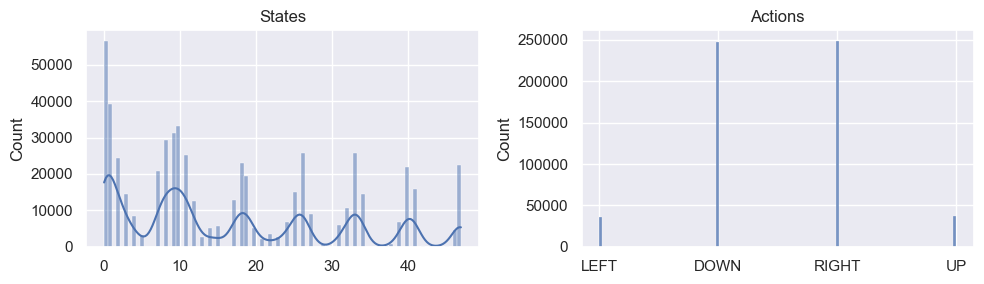

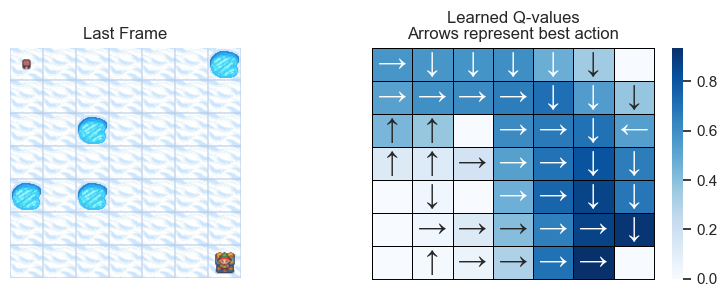

Grid size: 9x9


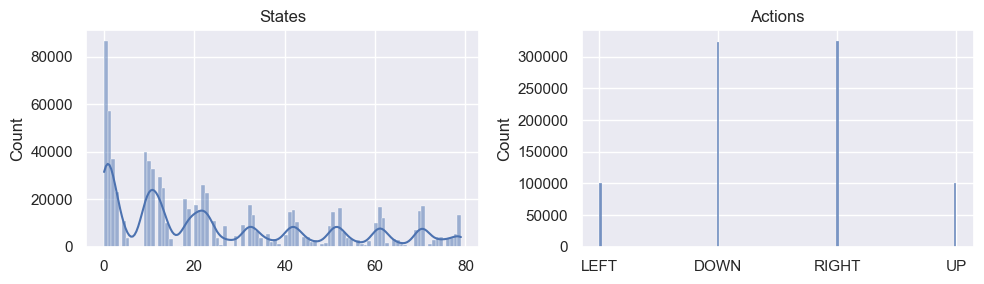

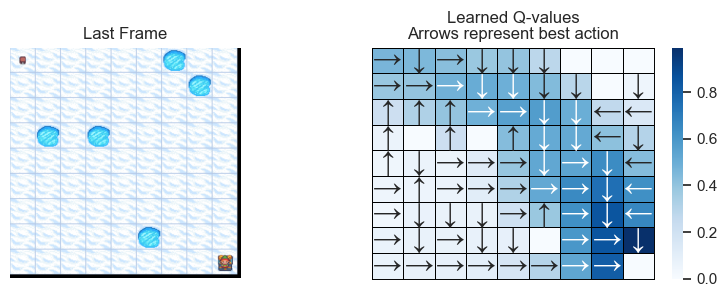

Grid size: 11x11


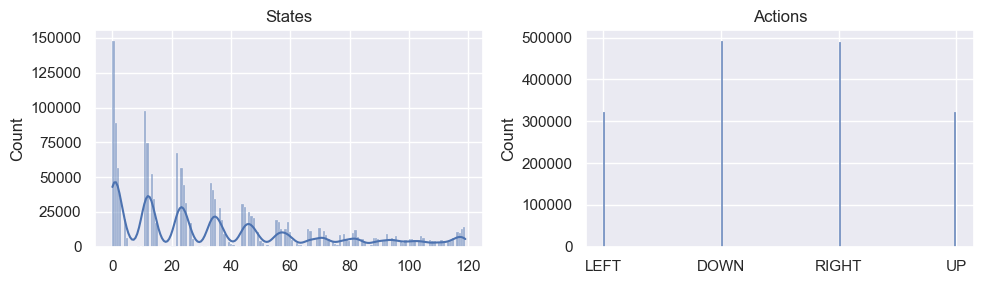

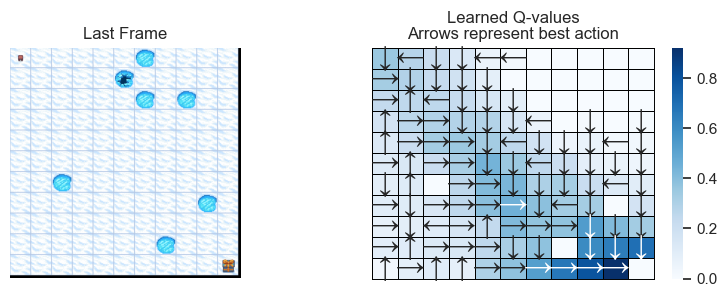

In [12]:
grid_sizes = [4, 7, 9, 11]
results_all = pd.DataFrame()
summary_all = pd.DataFrame()

for grid_size in grid_sizes:
    environment = gym.make(
        "FrozenLake-v1",
        is_slippery=simulationparams.terrain_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=grid_size, p=simulationparams.frozen_tile_probability, seed=simulationparams.random_seed
        ),
    )

    simulationparams = simulationparams._replace(num_actions=environment.action_space.n)
    simulationparams = simulationparams._replace(num_states=environment.observation_space.n)
    environment.action_space.seed(
        simulationparams.random_seed
    )  # Set the seed to get reproducible results when sampling the action space
    
    learner = QLearningAgent(
        alpha=simulationparams.alpha,
        discount_factor=simulationparams.discount_factor,
        num_states=simulationparams.num_states,
        num_actions=simulationparams.num_actions,
    )
    
    explorer = EpsilonGreedyPolicy(
        exploration_prob=simulationparams.exploration_prob,
    )

    print(f"Grid size: {grid_size}x{grid_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = execute_simulation()

    # Save the results in dataframes
    results, summary = process_simulation_results(episodes, simulationparams, rewards, steps, grid_size)
    results_all = pd.concat([results_all, results])
    summary_all = pd.concat([summary_all, summary])
    avg_qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        all_states, all_actions, grid_size
    )  # Sanity check
    plot_best_actions_map(avg_qtable, environment, grid_size)

    environment.close()


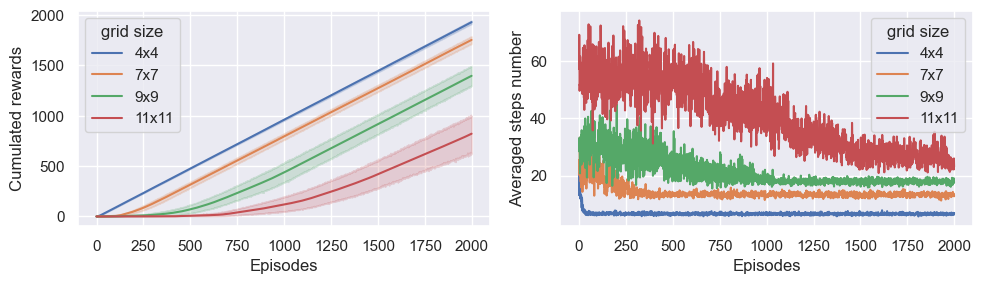

In [13]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="Cumulative_Rewards", hue="Grid_Size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Average_Steps", hue="Grid_Size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="grid size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(simulationparams.output_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(results_all, summary_all)

In [14]:
import gym
import numpy as np
import random
from tqdm import tqdm  # for progress bars

def train_qlearning(env, learning_rate, gamma, epsilon, total_episodes):
    """Train Q-learning agent."""
    qtable = np.zeros((env.observation_space.n, env.action_space.n))  # Initialize Q-table

    # Training loop
    for episode in tqdm(range(total_episodes), desc="Training Episodes"):
        state = env.reset(seed=simulationparams.random_seed)[0]  # Reset the environment
        done = False

        while not done:
            # Exploration-exploitation trade-off
            if rng.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(qtable[state])  # Exploitation

            # Take action and observe outcome
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update Q-table
            delta = reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
            qtable[state, action] += learning_rate * delta
            state = new_state  # Update current state

    return qtable

def evaluate_qlearning(env, qtable, total_episodes):
    """Evaluate the agent using the trained Q-table."""
    total_rewards = 0

    for episode in range(total_episodes):
        state = env.reset(seed=simulationparams.random_seed)[0]
        done = False

        while not done:
            action = np.argmax(qtable[state])  # Exploitation
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_rewards += reward

    return total_rewards / total_episodes  # Success rate

# Parameters
env = gym.make('FrozenLake-v1', is_slippery=True)
total_episodes = 1000
test_episodes = 100

# Hyperparameter combinations
learning_rates = [0.1, 0.5, 0.9]
gammas = [0.1, 0.8, 0.99]
epsilons = [0.1, 0.3, 0.5]

# Testing different combinations of hyperparameters
for learning_rate in learning_rates:
    for gamma in gammas:
        for epsilon in epsilons:
            # Train the agent
            qtable = train_qlearning(env, learning_rate, gamma, epsilon, total_episodes)
            # Evaluate the agent
            success_rate = evaluate_qlearning(env, qtable, test_episodes)
            print(
                f"Learning Rate: {learning_rate}, Gamma: {gamma}, Epsilon: {epsilon}, Success Rate: {success_rate}"
            )


Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]s:\Softwares\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6662.09it/s]


Learning Rate: 0.1, Gamma: 0.1, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6833.76it/s]


Learning Rate: 0.1, Gamma: 0.1, Epsilon: 0.3, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6464.59it/s]


Learning Rate: 0.1, Gamma: 0.1, Epsilon: 0.5, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6927.33it/s]


Learning Rate: 0.1, Gamma: 0.8, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6542.07it/s]


Learning Rate: 0.1, Gamma: 0.8, Epsilon: 0.3, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6420.21it/s]


Learning Rate: 0.1, Gamma: 0.8, Epsilon: 0.5, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5083.07it/s]


Learning Rate: 0.1, Gamma: 0.99, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5577.73it/s]


Learning Rate: 0.1, Gamma: 0.99, Epsilon: 0.3, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4757.81it/s]


Learning Rate: 0.1, Gamma: 0.99, Epsilon: 0.5, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5621.33it/s]


Learning Rate: 0.5, Gamma: 0.1, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5828.11it/s]


Learning Rate: 0.5, Gamma: 0.1, Epsilon: 0.3, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6206.41it/s]


Learning Rate: 0.5, Gamma: 0.1, Epsilon: 0.5, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5524.35it/s]


Learning Rate: 0.5, Gamma: 0.8, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5007.94it/s]


Learning Rate: 0.5, Gamma: 0.8, Epsilon: 0.3, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4375.37it/s]


Learning Rate: 0.5, Gamma: 0.8, Epsilon: 0.5, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4629.50it/s]


Learning Rate: 0.5, Gamma: 0.99, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 3447.84it/s]


Learning Rate: 0.5, Gamma: 0.99, Epsilon: 0.3, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4121.85it/s]


Learning Rate: 0.5, Gamma: 0.99, Epsilon: 0.5, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4763.20it/s]


Learning Rate: 0.9, Gamma: 0.1, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4554.10it/s]


Learning Rate: 0.9, Gamma: 0.1, Epsilon: 0.3, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6516.27it/s]


Learning Rate: 0.9, Gamma: 0.1, Epsilon: 0.5, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 4888.93it/s]


Learning Rate: 0.9, Gamma: 0.8, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6147.64it/s]


Learning Rate: 0.9, Gamma: 0.8, Epsilon: 0.3, Success Rate: 1.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6631.43it/s]


Learning Rate: 0.9, Gamma: 0.8, Epsilon: 0.5, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6512.76it/s]


Learning Rate: 0.9, Gamma: 0.99, Epsilon: 0.1, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 5861.13it/s]


Learning Rate: 0.9, Gamma: 0.99, Epsilon: 0.3, Success Rate: 0.0


Training Episodes: 100%|██████████| 1000/1000 [00:00<00:00, 6631.06it/s]

Learning Rate: 0.9, Gamma: 0.99, Epsilon: 0.5, Success Rate: 0.0


In [15]:
import gym
import numpy as np

def policy_evaluation(environment, policy_matrix, gamma=0.99, theta=1e-6):
    state_values = np.zeros(environment.observation_space.n)
    while True:
        max_delta = 0
        for state_index in range(environment.observation_space.n):
            current_value = 0
            for action_index, action_probability in enumerate(policy_matrix[state_index]):
                for transition_prob, next_state, reward, _ in environment.P[state_index][action_index]:
                    current_value += action_probability * transition_prob * (reward + gamma * state_values[next_state])
            max_delta = max(max_delta, np.abs(current_value - state_values[state_index]))
            state_values[state_index] = current_value
        if max_delta < theta:
            break
    return state_values

def policy_improvement(environment, state_values, discount_factor=0.99):
    policy_matrix = np.zeros([environment.observation_space.n, environment.action_space.n])
    for state_index in range(environment.observation_space.n):
        q_values = np.zeros(environment.action_space.n)
        for action_index in range(environment.action_space.n):
            for transition_prob, next_state, reward, _ in environment.P[state_index][action_index]:
                q_values[action_index] += transition_prob * (reward + discount_factor * state_values[next_state])
        best_action = np.argmax(q_values)
        policy_matrix[state_index, best_action] = 1
    return policy_matrix

def policy_iteration(environment, discount_factor=0.99):
    policy_matrix = np.ones([environment.observation_space.n, environment.action_space.n]) / environment.action_space.n
    while True:
        state_values = policy_evaluation(environment, policy_matrix, discount_factor)
        updated_policy = policy_improvement(environment, state_values, discount_factor)
        if np.array_equal(updated_policy, policy_matrix):
            break
        policy_matrix = updated_policy
    return policy_matrix

def evaluate_policy(environment,policy_matrix, total_episodes):
    total_rewards = 0
    for _ in range(total_episodes):
        state = environment.reset()
        if isinstance(state, tuple):  # Handle environments that return (state, info)
            state = state[0]
        simulation_done = False
        while not simulation_done:
            action = np.argmax(policy_matrix[state])  # Exploitation
            state, reward, terminated, truncated, _ = environment.step(action)
            simulation_done = terminated or truncated
            total_rewards += reward
    return total_rewards / total_episodes

# Parameters
environment = gym.make('FrozenLake-v1')
total_episodes = 1000
test_episodes = 100

# Hyperparameters to test
gammas = [0.1, 0.8, 0.99]

# Testing Policy Iteration
for gamma in gammas:
    computed_policy = policy_iteration(environment, gamma)
    success_rate = evaluate_policy(environment, computed_policy, test_episodes)
    print(f'Gamma: {gamma}, Success Rate: {success_rate}')


Gamma: 0.1, Success Rate: 0.5
Gamma: 0.8, Success Rate: 0.51
Gamma: 0.99, Success Rate: 0.68


**Part2**

In [16]:
!pip3 install atari_py
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install "stable-baselines3[extra]>=2.0.0a4"
!pip3 install gym
!pip3 install opencv-python

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 69.5.1).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-312\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-312\Box2D
      creating build\lib.win-amd64-cpython-312\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-312\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
      error: comman

In [17]:
import torch as th
import cv2
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold, EvalCallback
import random
import warnings
warnings.filterwarnings('ignore')

In [18]:
class AtariGameSimulator:
    def __init__(self, environment_paths, rendering_mode, best_model_save_paths, model_save_paths, video_save_paths):
        self.environment_paths = environment_paths
        self.rendering_mode = rendering_mode
        self.best_model_save_paths = best_model_save_paths
        self.model_save_paths = model_save_paths
        self.video_save_paths = video_save_paths

    def initialize_environment(self, environment_index):
        self.environment_index = environment_index
        environment_instance = gym.make(self.environment_paths[self.environment_index], render_mode=self.rendering_mode)
        self.environment_wrapper = DummyVecEnv([lambda: environment_instance])

    def train_agent(self, training_timesteps, episodes, policy_parameters, reward_goal, evaluation_frequency):
        reward_threshold_callback = StopTrainingOnRewardThreshold(reward_threshold=reward_goal, verbose=1)
        evaluation_callback = EvalCallback(self.environment_wrapper,
                                      callback_on_new_best=reward_threshold_callback,
                                      eval_freq=evaluation_frequency,
                                      best_model_save_path=self.best_model_save_paths[0],
                                      verbose=1)


        self.agent_model = PPO("MlpPolicy", self.environment_wrapper,  verbose=1, policy_kwargs=policy_parameters)
        self.agent_model.learn(total_timesteps=training_timesteps, callback=evaluation_callback)
        evaluate_policy(self.agent_model, self.environment_wrapper, n_eval_episodes=episodes, render=True)

        self.agent_model.save(self.model_save_paths[self.environment_index])
        del self.agent_model

    def test_agent(self, episodes, frame_rate):
        loaded_model = PPO.load(self.model_save_paths[self.environment_index], env=self.environment_wrapper)
        initial_observation= self.environment_wrapper.reset()
        frame_size = (self.environment_wrapper.render().shape[1], self.environment_wrapper.render().shape[0])

        video_codec = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(self.video_save_paths[self.environment_index],  video_codec, frame_rate, frame_size)
        for episode in range(1, episodes+1):
            observation = self.environment_wrapper.reset()
            score = 0
            simulation_done = False

            while not simulation_done:
                frame = self.environment_wrapper.render()
                action, _ = loaded_model.predict(observation)
                observation, reward, simulation_done, _ = self.environment_wrapper.step(action)
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                video_writer.write(frame_bgr)
                score+=reward

            print(f"Episode: {episode}, Score: {score}")
        video_writer.release()

In [19]:
environment_instance = ('CartPole-v1', "LunarLander-v2", "SpaceInvaders-v4")

# Render mode
rendering_mode = "rgb_array"

# Path to the best reward
best_model_save_paths = ("CartPole-v1-BEST", "LunarLander-v2-BEST", "SpaceInvaders-v4")

# Path to model
model_save_paths = ("cart_pole_model.zip", "lunar_landler.zip", "space_invaders.zip")

# Path to Video
video_save_paths = ("CartPole-video.mp4", "LunarLander-video.mp4", "SpaceInvaders-video.mp4")

policy_kwargs = dict(policy_layer=[64, 128, 128, 64], value_layer=[64, 128, 128, 64])
activation_fun=th.nn.ReLU
custom_policy_kwargs = dict(net_arch=policy_kwargs, activation_fn=activation_fun)

game_simulator = AtariGameSimulator(environment_instance, rendering_mode, best_model_save_paths, model_save_paths, video_save_paths)

In [20]:
# CartPole game
game_simulator.initialize_environment(environment_index=0)

game_simulator.train_agent(
    training_timesteps=100000, 
    episodes=10, 
    policy_parameters=custom_policy_kwargs, 
    reward_goal=500, 
    evaluation_frequency=18000
)

game_simulator.test_agent(
    episodes=10, 
    frame_rate=35
)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2959 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1988         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0031585693 |
|    clip_fraction        | 0.00166      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | -0.0119      |
|    learning_rate        | 0.0003       |
|    loss                 | 51.5         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00422     |
|    value_loss           | 93.5         |
------------------------------------------